In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from env import get_db_url

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_regression, RFE

In [2]:
url = get_db_url('telco_churn')

query = '''
SELECT * FROM customers
JOIN contract_types USING (contract_type_id)
JOIN internet_service_types USING (internet_service_type_id)
JOIN payment_types USING (payment_type_id)
'''
df_orig = pd.read_sql(query, url)

In [3]:
df = df_orig.copy()
#Encoding gender feature to be used later in modeling
df['gender_encoded'] = (df['gender'] == 'Male').astype(int)

In [4]:
df.tech_support.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64

In [5]:
#Creating single variable to represent if the user has 0, 1, or 
#more than 1 phone line, 0 being if the user has no phone service
df['number_of_lines'] = df.multiple_lines.replace({'Yes':2, 'No':1,\
                                        'No phone service':0})

df.drop(columns=['multiple_lines','phone_service'], inplace=True)

In [6]:
#Drop all total charges that are represented in the data with ' '.
df.total_charges.replace(' ', np.nan, inplace=True)
df.dropna(inplace=True)
df.total_charges = df.total_charges.astype(float)

#Encoding yes's and no's to be used later in modeling
df.replace('Yes', 1, inplace=True)
df.replace('No', 0, inplace=True)
df.replace('No internet service', 2, inplace=True)
df.replace('No phone service', 2, inplace=True)

In [7]:
#Creating new feature, which is tenure in whole years
df['tenure_years'] = (df.tenure / 12).astype(int)

In [8]:
# Sorting the columns by my preference
df = df[['customer_id', 'gender','gender_encoded','senior_citizen',
         'partner', 'dependents', 'number_of_lines',
         'online_security', 'online_backup', 'device_protection', 
         'tech_support', 'streaming_tv', 'streaming_movies', 
         'paperless_billing', 'tenure', 'tenure_years',
         'monthly_charges', 'total_charges', 'churn', 
         'payment_type', 'payment_type_id','internet_service_type', 
         'internet_service_type_id', 
         'contract_type', 'contract_type_id', ]]

In [9]:
train, test = train_test_split(df, train_size = .8, random_state=42)
train, validate = train_test_split(train, train_size = .8, 
                                   random_state=42)

In [10]:
#Separate train data to use when scaling
#This drops non-numeric data
train_nums = train.drop(columns=['customer_id','gender',
            'payment_type','internet_service_type','contract_type'])
val_nums = validate.drop(columns=['customer_id','gender',
            'payment_type','internet_service_type','contract_type'])

In [11]:
train['bins'] = pd.cut(train.monthly_charges, [0,20,40,60,80,100,120], 
                       labels=[0,1,2,3,4,5])
# train['monthly_bins'] = train.groupby(bins)['monthly_charges']
# sorted(train.bins.value_counts())
pd.crosstab(train['churn'], train['bins'])

bins,0,1,2,3,4,5
churn,,,,,,
0,390,662,495,632,695,415
1,43,95,183,315,425,150


In [12]:
train[['monthly_charges','bins']].sample(5)

,monthly_charges,bins
4607,105.40,5
6893,20.05,1
6261,19.15,0
873,35.15,1
6063,19.45,0


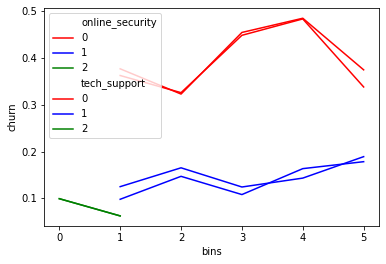

In [13]:
import warnings
warnings.simplefilter(action='ignore')

sns.lineplot('bins', 'churn', data = train, err_style=None,
             hue='online_security', palette=['r','b','g'])
sns.lineplot('bins', 'churn', data = train, err_style=None,
             hue='tech_support', palette=['r','b','g'])

In [14]:
list(train.columns)

['customer_id',
 'gender',
 'gender_encoded',
 'senior_citizen',
 'partner',
 'dependents',
 'number_of_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'tenure',
 'tenure_years',
 'monthly_charges',
 'total_charges',
 'churn',
 'payment_type',
 'payment_type_id',
 'internet_service_type',
 'internet_service_type_id',
 'contract_type',
 'contract_type_id',
 'bins']

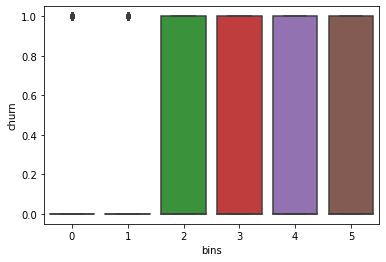

In [15]:
sns.boxplot(train.bins, train.churn)

In [16]:
train.bins[train.number_of_lines==0].value_counts()

1    197
2    194
3     37
5      0
4      0
0      0
Name: bins, dtype: int64

In [17]:
train.churn[train.number_of_lines==1][train.bins==2].count()

392

In [18]:
train.churn[train.number_of_lines==0][train.bins==3].sum()

1

In [19]:
# plt.rc('figure',figsize=(12,9))
# sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
#              hue='partner', palette='Blues')
# sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
#              hue='dependents', palette='Reds')

This seems to say that the least likely group to churn of these 4 is that with dependents, only being matched by the other groups once tenure reaches more than 5 years

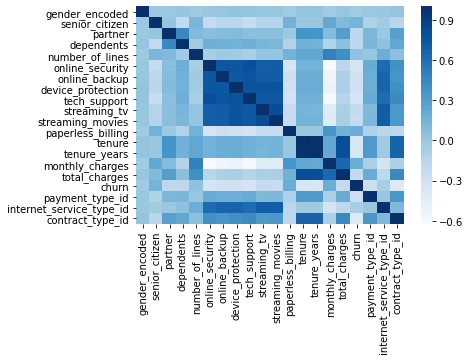

In [20]:
sns.heatmap(train.corr(), cmap='Blues')

This shows that the group of columns near the middle are closely correlated with each other, and therefore I believe only one should be used for modeling. This is obviously also true for tenure and tenure_years.

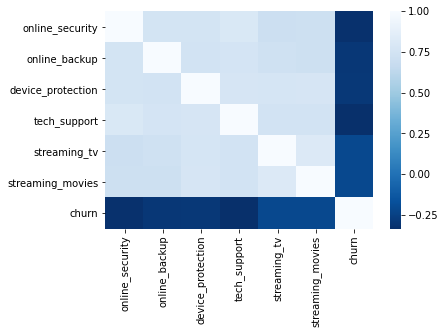

In [21]:
binary_features = train[['online_security','online_backup',
                   'device_protection', 'tech_support',
                   'streaming_tv','streaming_movies', 'churn']]
sns.heatmap(binary_features.corr(), cmap='Blues_r')

In [22]:
binary_features.corr().iloc[-1].nsmallest(2)

tech_support      -0.333430
online_security   -0.327007
Name: churn, dtype: float64

In [23]:
train.corr().iloc[16].sort_values()[0:8]

contract_type_id    -0.403699
tenure              -0.364808
tenure_years        -0.356645
tech_support        -0.333430
online_security     -0.327007
online_backup       -0.293977
device_protection   -0.289563
payment_type_id     -0.266530
Name: churn, dtype: float64

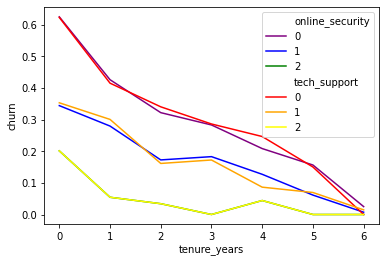

In [24]:
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
        hue='online_security', palette=['Purple','Blue','Green'])
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
        hue='tech_support', palette=['Red','Orange','Yellow'])

This shows that the two most highly correlated of that earlier colletion of columns are so similar that it barely makes a difference, so I will be choosing tech support, since that was slightly more correlated.

In [25]:
def onehot_encode(column):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit_transform(train[column])
    cols = [c for c in encoder.categories_[0]]
    m_train = encoder.transform(train[[column]])
    encoded_train = pd.DataFrame(m_train, columns=cols,index=train.index)
    train = train.join(encoded_train).drop(columns=[column])

In [26]:
train.head()

,customer_id,gender,gender_encoded,senior_citizen,partner,dependents,number_of_lines,online_security,online_backup,device_protection,...,monthly_charges,total_charges,churn,payment_type,payment_type_id,internet_service_type,internet_service_type_id,contract_type,contract_type_id,bins
5217,3134-DSHVC,Female,0,0,0,0,2,1,1,1,...,98.00,6218.45,0,Credit card (automatic),4,Fiber optic,2,Two year,3,4
5496,9586-JGQKH,Female,0,0,1,0,2,0,1,0,...,105.40,6794.75,0,Bank transfer (automatic),3,Fiber optic,2,Two year,3,5
4517,9874-QLCLH,Female,0,0,1,1,2,1,0,1,...,104.20,1743.50,1,Electronic check,1,Fiber optic,2,Month-to-month,1,5
5121,0835-JKADZ,Female,0,0,0,0,2,0,1,1,...,111.25,7984.15,0,Electronic check,1,Fiber optic,2,Two year,3,5
5322,5693-PIPCS,Male,1,0,0,0,1,0,1,0,...,99.65,4220.35,0,Credit card (automatic),4,Fiber optic,2,Two year,3,4


In [28]:
df.churn.mean()

0.26578498293515357

In [27]:
onehot_encode('contract_type_id')
onehot_encode('tech_support')
onehot_encode('payment_type_id')

UnboundLocalError: local variable 'train' referenced before assignment

In [ ]:
train.head(3)

In [30]:
features = ['contract_type_id','tenure_years','tech_support',
            'payment_type_id']
X_train = train[features]
y_train = train.churn
X_val = validate[features]
y_val = validate.churn

In [ ]:
sorted(features)

In [ ]:
selector = (SelectKBest(f_regression, k=8).fit(train_nums, y_train))
X = selector.transform(train_nums)
support = selector.get_support()
train_nums.columns[support].tolist()

In [36]:
scaler = MinMaxScaler().fit(train_nums)
train_scaled = pd.DataFrame(scaler.transform(train_nums), 
                            columns = train_nums.columns.values)\
                            .set_index([train_nums.index.values])
val_scaled = pd.DataFrame(scaler.transform(val_nums), 
                            columns = val_nums.columns.values)\
                            .set_index([val_nums.index.values])
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled.churn
X_val_scaled = val_scaled[features]
y_val_scaled = val_scaled.churn

In [ ]:
X_train_scaled.head()

In [31]:
rf = LogisticRegression(random_state=42).fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_val, y_val)

(0.778, 0.7662222222222222)

In [38]:
classification_report(train.churn, )

<function sklearn.metrics.classification.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)>

In [32]:
rf = DecisionTreeClassifier(max_depth=3, random_state=42)\
      .fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_val, y_val)

(0.7797777777777778, 0.7697777777777778)

In [33]:
rf = RandomForestClassifier(random_state=42, min_samples_leaf = 3,
                            max_depth = 5).fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_val, y_val)

(0.7873333333333333, 0.7617777777777778)

In [34]:
rf = KNeighborsClassifier().fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_val, y_val)

(0.7788888888888889, 0.7662222222222222)

In [37]:
rf = KNeighborsClassifier().fit(X_train_scaled, y_train_scaled)
rf.score(X_train_scaled, y_train_scaled),\
rf.score(X_val_scaled, y_val_scaled)

(0.7777777777777778, 0.7644444444444445)